In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

In [33]:
from model.mrcnn.config import Config
from model.mrcnn import utils
import model.mrcnn.model as modellib
from model.mrcnn import visualize
from model.mrcnn.model import log
from model.mrcnn import data_generator as datagen
from model.mrcnn import image_meta as meta
from model.mrcnn import dataset

%matplotlib inline 

In [34]:
from data.pascalvoc.pascal_frcnn import PascalVOCDataset

In [35]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(os.environ['HOME'], 'partial_experiments')

# Local path to trained weights file MEH
COCO_MODEL_PATH = os.path.join(os.environ['HOME'], "partial-labels/experiments/frcnn", "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [36]:
from keras.preprocessing import image as k_image
from keras.applications.imagenet_utils import preprocess_input

In [37]:
from collections import defaultdict

from pprint import pprint

In [38]:
class PascalConfig(Config):
    """
    Configuration for training on the Pascal dataset.
    Derives from the base Config class and overrides values specific to Pascal
    """
    # Give the configuration a recognizable name
    NAME = "pascal"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NB_CLASSES = 20 + 1

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 448
    IMAGE_MAX_DIM = 448

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (64, 128, 256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    STEPS_PER_EPOCH = 627    # 5011 / 8 for trainval

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
    # old config
    IMG_SIZE = 448
    DATASET_PATH = '/local/DEEPLEARNING/pascalvoc/VOCdevkit/VOC2007'
    NB_CHANNELS = 3
    
config = PascalConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DATASET_PATH                   /local/DEEPLEARNING/pascalvoc/VOCdevkit/VOC2007
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  448
IMAGE_META_SIZE                33
IMAGE_MIN_DIM                  448
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [448 448   3]
IMG_SIZE                       448
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_los

In [39]:
def get_ax(rows=1, cols=1, size=8):
    """
    Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Pascal Dataset

In [40]:
# Training dataset
dataset_train = PascalVOCDataset()
dataset_train.load_pascal(config.DATASET_PATH, 8, 'trainval', config)
dataset_train.prepare()

loaded annotations in 0.6986801624298096
Registered images in 0.007415056228637695


In [41]:
# Validation dataset
dataset_val = PascalVOCDataset()
dataset_val.load_pascal(config.DATASET_PATH, 8, 'test', config)
dataset_val.prepare()

loaded annotations in 0.20770668983459473
Registered images in 0.006603717803955078


In [42]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 4)
print(image_ids)

[  87 1100   95 3467]


image id 87
(14, 4)
[101.54666667 215.04       303.44533333 258.048     ]
(14,)


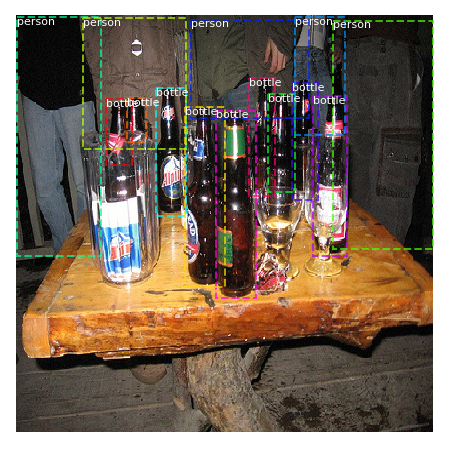

image id 1100
(14, 4)
[207.872      102.144      366.76266667 146.944     ]
(14,)


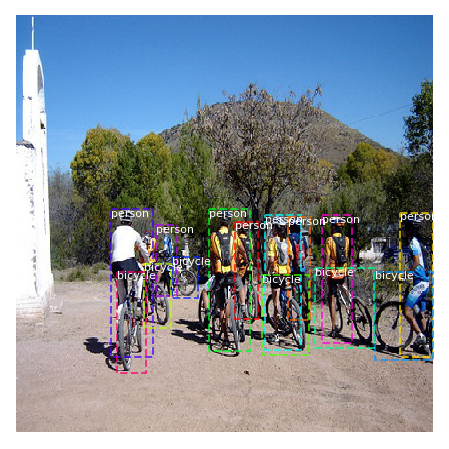

image id 95
(14, 4)
[162.176       39.01501502 447.104      197.76576577]
(14,)


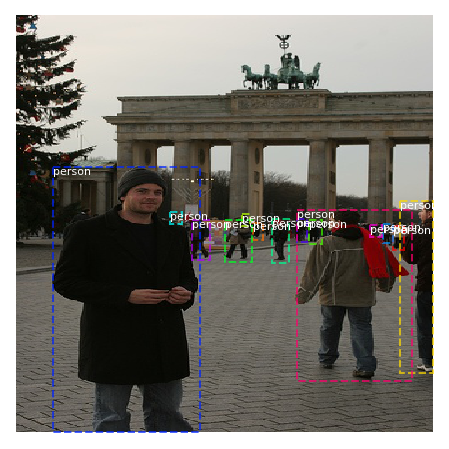

image id 3467
(1, 4)
[ 10.76276276   0.896      410.33033033 398.72      ]
(1,)


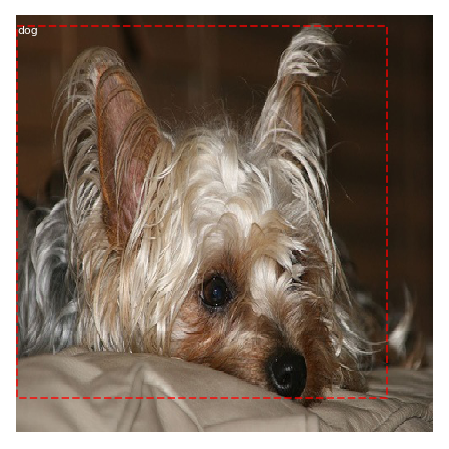

In [43]:
#image_ids = [55102]
for image_id in image_ids:
    print('image id %s' % image_id)
    img = dataset_val.load_image(image_id)
    bboxes, class_ids = dataset_val.load_bboxes(image_id)
    bboxes = np.array(bboxes)
    print(bboxes.shape)
    print(bboxes[0])
    
    class_ids = np.array(class_ids)
    print(class_ids.shape)
    
    visualize.display_instances(img, bboxes, class_ids, dataset_val.class_names, figsize=(8, 8))

## Model

In [44]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", 
                          config=config,
                          model_dir=MODEL_DIR)

In [45]:
# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

A local file was found, but it seems to be incomplete or outdated because the md5 file hash does not match the original value of a268eb855778b3df3c7506639542a6af so we will re-download the data.
94658560/94653016 [==============================] - 23s 0us/step


## training

In [24]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/caleml/partial_experiments/pascal20200127T1801/mask_rcnn_pascal_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_class_logits     (TimeDistributed)


/home/caleml/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/caleml/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
627/627 [==============================] - 210s 334ms/step - loss: 1.4339 - rpn_class_loss: 0.1095 - rpn_bbox_loss: 0.6070 - mrcnn_class_loss: 0.3564 - mrcnn_bbox_loss: 0.3610 - val_loss: 1.3204 - val_rpn_class_loss: 0.1064 - val_rpn_bbox_loss: 0.6316 - val_mrcnn_class_loss: 0.2918 - val_mrcnn_bbox_loss: 0.2906


In [46]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=20, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: /home/caleml/partial_experiments/pascal20200127T1831/mask_rcnn_pascal_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3

/home/caleml/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/caleml/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
627/627 [==============================] - 442s 706ms/step - loss: 3.9034 - rpn_class_loss: 0.4564 - rpn_bbox_loss: 1.3799 - mrcnn_class_loss: 1.2507 - mrcnn_bbox_loss: 0.8164 - val_loss: 3.6193 - val_rpn_class_loss: 0.4262 - val_rpn_bbox_loss: 1.3428 - val_mrcnn_class_loss: 1.1418 - val_mrcnn_bbox_loss: 0.7085
Epoch 2/20
627/627 [==============================] - 384s 612ms/step - loss: 3.1255 - rpn_class_loss: 0.2838 - rpn_bbox_loss: 1.0874 - mrcnn_class_loss: 1.0752 - mrcnn_bbox_loss: 0.6791 - val_loss: 3.0239 - val_rpn_class_loss: 0.2327 - val_rpn_bbox_loss: 1.1124 - val_mrcnn_class_loss: 0.9948 - val_mrcnn_bbox_loss: 0.6839
Epoch 3/20
627/627 [==============================] - 383s 612ms/step - loss: 2.9024 - rpn_class_loss: 0.2351 - rpn_bbox_loss: 1.0117 - mrcnn_class_loss: 1.0146 - mrcnn_bbox_loss: 0.6410 - val_loss: 2.8458 - val_rpn_class_loss: 0.2883 - val_rpn_bbox_loss: 0.8954 - val_mrcnn_class_loss: 1.0208 - val_mrcnn_bbox_loss: 0.6413
Epoch 4/20
627/627 [========

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



627/627 [==============================] - 386s 616ms/step - loss: 2.1688 - rpn_class_loss: 0.1549 - rpn_bbox_loss: 0.7802 - mrcnn_class_loss: 0.7426 - mrcnn_bbox_loss: 0.4911 - val_loss: 2.3666 - val_rpn_class_loss: 0.1547 - val_rpn_bbox_loss: 0.8649 - val_mrcnn_class_loss: 0.8239 - val_mrcnn_bbox_loss: 0.5231
Epoch 15/20
627/627 [==============================] - 385s 614ms/step - loss: 2.1386 - rpn_class_loss: 0.1518 - rpn_bbox_loss: 0.7713 - mrcnn_class_loss: 0.7298 - mrcnn_bbox_loss: 0.4855 - val_loss: 2.5736 - val_rpn_class_loss: 0.2204 - val_rpn_bbox_loss: 1.0093 - val_mrcnn_class_loss: 0.8254 - val_mrcnn_bbox_loss: 0.5186
Epoch 16/20
627/627 [==============================] - 385s 614ms/step - loss: 2.1055 - rpn_class_loss: 0.1489 - rpn_bbox_loss: 0.7611 - mrcnn_class_loss: 0.7162 - mrcnn_bbox_loss: 0.4793 - val_loss: 2.2388 - val_rpn_class_loss: 0.1805 - val_rpn_bbox_loss: 0.7221 - val_mrcnn_class_loss: 0.7970 - val_mrcnn_bbox_loss: 0.5391
Epoch 17/20
627/627 [================

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## detection

In [26]:
class InferenceConfig(PascalConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()


In [27]:

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join('/home/caleml/partial_experiments/openimages20200114T1558/', 'mask_rcnn_openimages_0002.h5')
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /home/caleml/partial_experiments/pascal20200127T1801/mask_rcnn_pascal_0001.h5
Re-starting from epoch 1


3684
original_image           shape: (448, 448, 3)         min:    0.00000  max:  255.00000  float32
image_meta               shape: (33,)                 min:    0.00000  max: 3684.00000  int64
gt_class_id              shape: (1,)                  min:    7.00000  max:    7.00000  int64
gt_bbox                  shape: (1, 4)                min:   21.59036  max:  430.97600  float64


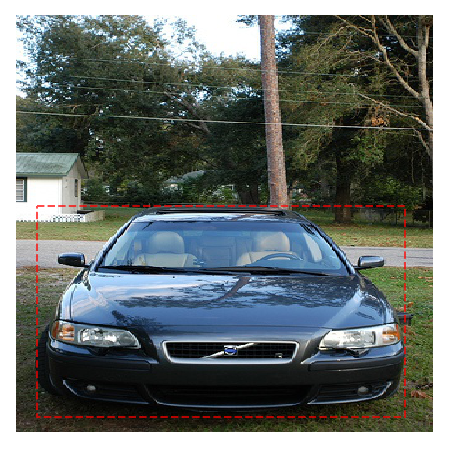

In [28]:

image_id = random.choice(dataset_val.image_ids)
print(image_id)
original_image, image_meta, gt_class_id, gt_bbox = datagen.load_image_gt(dataset_val, inference_config, image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)

visualize.display_instances(original_image, gt_bbox, gt_class_id, dataset_val.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (448, 448, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 448, 448, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 33)               min:    0.00000  max:  448.00000  int64
anchors                  shape: (1, 49392, 4)         min:   -0.40496  max:    1.36917  float32
[{'rois': array([[223,  24, 426, 443]], dtype=int32), 'class_ids': array([7], dtype=int32), 'scores': array([0.99518895], dtype=float32)}]


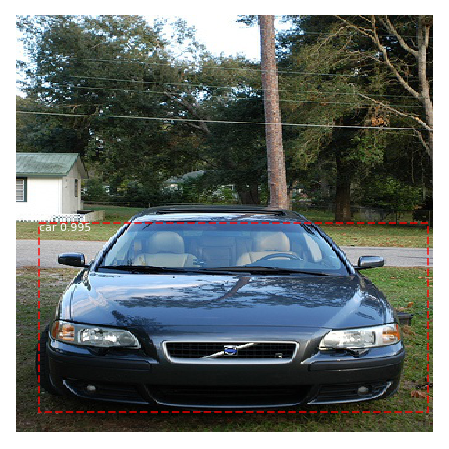

In [29]:
results = model.detect([original_image], verbose=1)

print(results)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['class_ids'], dataset_val.class_names, r['scores'], ax=get_ax())

## evaluation

In [30]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, 100)
APs = []
count = 0

for image_id in dataset_val.image_ids:
    count += 1
    if count % 1000 == 0:
        print("done %s val images, temp AP %s" % (count, np.mean(APs)))
    
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox = datagen.load_image_gt(dataset_val, inference_config, image_id)
    
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

done 1000 val images, temp AP 0.7614991235448526
done 2000 val images, temp AP 0.7653348520035443
done 3000 val images, temp AP 0.7645194440781978
done 4000 val images, temp AP 0.7594595832166069
mAP:  0.7600988079109441
